In [1]:
import os, shutil
from os import listdir
from os.path import isfile, join
import random

In [2]:
print(os.getcwd())

#creo lista di nomi 
directories = ['data/train/', 
               'data/val/', 
               'data/test/']

train_file_names = [f for f in listdir(directories[0]) if isfile(join(directories[0], f))]
val_file_names = [f for f in listdir(directories[1]) if isfile(join(directories[1], f))]
test_file_names = [f for f in listdir(directories[2]) if isfile(join(directories[2], f))]

_file_names = [train_file_names, val_file_names, test_file_names] 

/home/phil/unimib/tesi/src


In [3]:
#numero immagini per categoria
scans = ['CT','MRI','PET']
numbers=[]
minimi=[]

for directory in directories:    
    for scan in scans:
        a = len([f for f in listdir(directory) if f[:2]==scan[:2]])
        #print('Numbero di immagini', scan, 'in', directory,':', a)
        numbers.append(a)
    minimi.append(min(numbers))

#print(minimi)
#=> è sempre la PET che ha il numero minore

In [4]:
#creo la lista di file bilanciata: n.b  la percentuale viene mantenuta
train_final_file_names=[]
val_final_file_names=[]
test_final_file_names=[]
_final_file_names = [train_final_file_names, val_final_file_names, test_final_file_names] 

l=[]
for directory,minimo,name in zip(directories, minimi,_final_file_names):    
    for scan in scans:
        l = [f for f in listdir(directory) if f[:2]==scan[:2]]
        random.shuffle(l)
        l = l[:minimo]
        name.extend(l) #estendo la lista (don't append)
        
# How I cicled ^^^

#    minimo |
#    name   |
#    train  | val | test
# 
# CT    ... | ... | ...
# MRI   ... | ... | ...
# PET   ... | ... | ...

In [5]:
print("DATASET")
print("Training", len(train_final_file_names), ", Validation:", len(val_final_file_names) ,", Test:", len(test_final_file_names))

DATASET
Training 858 , Validation: 342 , Test: 171


## Converto le immagini in tensori

In [6]:
from skimage import io
import matplotlib.pyplot as plt
import cv2

### X

In [7]:
def WriteAndArrayImages(path):
    x = io.imread(path[random.randint(0,10)])
    x = cv2.resize(x, dsize=(128,128))
    
    for img in path[1:]:
        img = io.imread(img)
        img = cv2.resize(img, dsize=(128,128))
        x = np.dstack((x,img))
    x = np.rollaxis(x,-1)
    return x

(858, 128, 128)
(342, 128, 128)
(171, 128, 128)


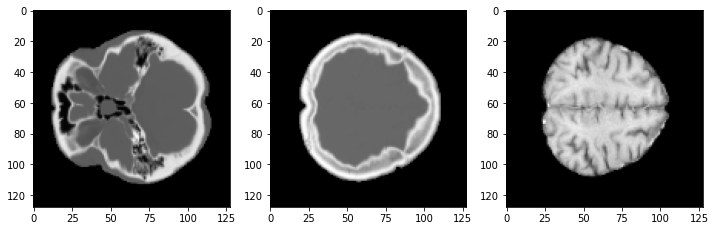

In [8]:
import numpy as np

#paths per leggere le immagini
train_paths=[]
val_paths=[]
test_paths=[]
_paths=[train_paths,val_paths,test_paths]

for path,name,directory in zip(_paths,_final_file_names,directories):
    for f in name:
        path.append(directory+f)

#leggo le immagini e le stacco una sopra l'altra
x_train = WriteAndArrayImages(train_paths)
x_val = WriteAndArrayImages(val_paths)
x_test = WriteAndArrayImages(test_paths)

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

#plot images from each dataset
f, axarr = plt.subplots(1,3,figsize=(15, 15))
axarr[0].imshow(x_train[random.randint(0,100)], cmap=plt.cm.gray)
axarr[1].imshow(x_val[random.randint(0,100)], cmap=plt.cm.gray)
axarr[2].imshow(x_test[random.randint(0,100)], cmap=plt.cm.gray)

### Y

In [9]:
def MakeLabels(_name_files):
    y=[]
    for text in _name_files:
        fileNameOnly = text[:text.find(ext)]
        y.append(''.join([i for i in fileNameOnly if not i.isdigit()]))
    for i, item in enumerate(y):
        if item == 'CT':
            y[i] = 0
        elif item == 'MRI':
            y[i] = 1
        else: y[i] = 2    
    y = np.concatenate((y,))
    return y

In [10]:
#estensione immagini
ext = '.png'

#costruisco le lables
y_train = MakeLabels(_final_file_names[0])
y_val = MakeLabels(_final_file_names[1])
y_test = MakeLabels(_final_file_names[2])

In [11]:
#check
X = [x_train, x_val, x_test]
Y = [y_train, y_val, y_test]

for x,y in zip(X,Y):
    if len(x) != len(y):
        print(len(x))
        print(len(y))
        print('Error! La lunghezza delle liste non combacia!')
    else: 
        print('Ok, le lunghezze combaciano con le X')

#controlla numero di cluster (expected 3)
n_clusters = len(np.unique(y))
print('Clusters:', n_clusters)

Ok, le lunghezze combaciano con le X
Ok, le lunghezze combaciano con le X
Ok, le lunghezze combaciano con le X
Clusters: 3


### Reshape images for autoencoder

In [16]:
#use this function for reshaping arrays for CAE
def ReshapeCAE(array):
    array = array.reshape(array.shape + (1,))
    array = array/255.
    return array

x_train = ReshapeCAE(x_train)
x_val = ReshapeCAE(x_val)
x_test = ReshapeCAE(x_test)

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(858, 128, 128, 1)
(342, 128, 128, 1)
(171, 128, 128, 1)


# Convolutional Autoencoder

In [12]:
from keras.models import Model
from keras import backend as K
from keras import layers
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Conv2DTranspose
from keras.models import Model

Using TensorFlow backend.


## CAE Conv2DTranspose (paper)

In [34]:
def CAE_Conv2DTranspose(input_shape=(128, 128, 1), filters=[32, 64, 128, 256, 512, 1024, 3]):
    
    '''
    CAE_Upsampling2D convolutional autoencoder model.
    
    Arguments:
        img_shape: (128, 128, 1)
        filters: [32, 64, 128, 256, 512, 1024, 3]
    
    return:
        Models of autoencoder and encoder
            (autoencoder, encoder)
            
        outputs:
            autoencoder: encoded
            encoder: decoded
    '''
    
    input_img = Input(shape=input_shape)
    
    #Encoder
    x = Conv2D(filters[0], 3, strides=2, padding='same', activation='relu', name='conv1', input_shape=input_shape)(input_img)
    x = Conv2D(filters[1], 3, strides=2, padding='same', activation='relu', name='conv2')(x)
    x = Conv2D(filters[2], 3, strides=2, padding='same', activation='relu', name='conv3')(x)
    x = Conv2D(filters[3], 3, strides=2, padding='same', activation='relu', name='conv4')(x)
    x = Conv2D(filters[4], 3, strides=2, padding='same', activation='relu', name='conv5')(x)
    x = Conv2D(filters[5], 3, strides=2, padding='same', activation='relu', name='conv6')(x)
    
    x = Flatten()(x)
    
    encoded = Dense(units=filters[6], name='embedding')(x)
    
    #Decoder
    x = Dense(units=filters[5]*int(input_shape[0]/32)*int(input_shape[0]/32), activation='relu')(encoded)

    # Reshape into an image of the same shape as before our last `Flatten` layer
    x = Reshape((int(input_shape[0]/32), int(input_shape[0]/32), filters[5]))(x)
    
    x = Conv2DTranspose(filters[3], 3, strides=2, padding='same', activation='relu', name='deconv5')(x)
    x = Conv2DTranspose(filters[2], 3, strides=2, padding='same', activation='relu', name='deconv4')(x)
    x = Conv2DTranspose(filters[1], 3, strides=2, padding='same', activation='relu', name='deconv3')(x)
    x = Conv2DTranspose(filters[0], 3, strides=2, padding='same', activation='relu', name='deconv2')(x)

    decoded = Conv2DTranspose(input_shape[2], 3, strides=2, padding='same', name='deconv1')(x)
    
    return Model(inputs=input_img, outputs=decoded, name='CAE_Conv2DTranspose'), Model(inputs=input_img, outputs=encoded, name='CE')

## CAE UpSampling2D

In [ ]:
def CAE_Upsampling2D(input_shape=(128, 128, 1), filters=[32, 64, 128, 256, 512, 1024, 3]):
    
    '''
    CAE_Upsampling2D convolutional autoencoder model.
    Arguments:
        img_shape: (128, 128, 1)
        filters: [32, 64, 128, 256, 512, 1024, 3]
    return:
        (autoencoder, encoder): Models of autoencoder and encoder
    '''
    
    input_img = Input(shape=input_shape)
    #Encoder
    x = Conv2D(filters[0], 3, strides=2, padding='same', activation='relu', name='conv1', input_shape=input_shape)(input_img)
    x = Conv2D(filters[1], 3, strides=2, padding='same', activation='relu', name='conv2')(x)
    x = Conv2D(filters[2], 3, strides=2, padding='same', activation='relu', name='conv3')(x)
    x = Conv2D(filters[3], 3, strides=2, padding='same', activation='relu', name='conv4')(x)
    x = Conv2D(filters[4], 3, strides=2, padding='same', activation='relu', name='conv5')(x)
    x = Conv2D(filters[5], 3, strides=2, padding='same', activation='relu', name='conv6')(x)
    shape_before_flattening = K.int_shape(x)
    
    x = Flatten()(x)
    
    encoded = Dense(units=filters[6], name='embedding')(x)
    
    #Decoder
    x = Dense(units=filters[5]*int(input_shape[0]/32)*int(input_shape[0]/32), activation='relu')(encoded)

    # Reshape into an image of the same shape as before our last `Flatten` layer
    x = Reshape((int(input_shape[0]/32), int(input_shape[0]/32), filters[5]))(x)

    x = Conv2D(filters[5], 3, padding='same', activation='relu', name='conv7')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(filters[4], 3, padding='same', activation='relu', name='conv8')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(filters[3], 3, padding='same', activation='relu', name='conv9')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(filters[2], 3, padding='same', activation='relu', name='conv10')(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(filters[1], 3, padding='same', activation='relu', name='conv11')(x)
    x = UpSampling2D((2, 2))(x)
    
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    return Model(inputs=input_img, outputs=decoded, name='CAE_Upsampling2D'), Model(inputs=input_img, outputs=encoded, name='CE')


In [35]:
# CAE_Conv2DTranspose, CAE_Upsampling2D

autoencoder, encoder = CAE_Conv2DTranspose()
encoder.summary()
autoencoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128, 128, 1)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        320       
_________________________________________________________________
conv2 (Conv2D)               (None, 32, 32, 64)        18496     
_________________________________________________________________
conv3 (Conv2D)               (None, 16, 16, 128)       73856     
_________________________________________________________________
conv4 (Conv2D)               (None, 8, 8, 256)         295168    
_________________________________________________________________
conv5 (Conv2D)               (None, 4, 4, 512)         1180160   
_________________________________________________________________
conv6 (Conv2D)               (None, 2, 2, 1024)        4719

# Pretrain

In [36]:
from keras.initializers import VarianceScaling
from keras.optimizers import SGD

#init = VarianceScaling(scale=1. / 3., mode='fan_in', distribution='uniform')

pretrain_epochs = 500 #####
batch_size = 16 #####

In [37]:
#dir results
save_dir = './results'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [38]:
from keras.callbacks import TensorBoard

autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.fit(x_train, 
                x_train, 
                batch_size=batch_size, 
                epochs=pretrain_epochs, 
                validation_data=(x_val, x_val),
                shuffle=True,
                use_multiprocessing=True,
                #callbacks=[TensorBoard(log_dir='/tmp/autoencoder')]
               )

Train on 858 samples, validate on 342 samples
Epoch 1/500
858/858 [==============================] - 62s 72ms/step - loss: 0.0482 - val_loss: 0.0165
Epoch 2/500
858/858 [==============================] - 59s 69ms/step - loss: 0.0147 - val_loss: 0.0123
Epoch 3/500
858/858 [==============================] - 65s 75ms/step - loss: 0.0096 - val_loss: 0.0079
Epoch 4/500
858/858 [==============================] - 55s 64ms/step - loss: 0.0087 - val_loss: 0.0097
Epoch 5/500
858/858 [==============================] - 54s 63ms/step - loss: 0.0079 - val_loss: 0.0068
Epoch 6/500
858/858 [==============================] - 58s 68ms/step - loss: 0.0075 - val_loss: 0.0068
Epoch 7/500
858/858 [==============================] - 52s 60ms/step - loss: 0.0074 - val_loss: 0.0063
Epoch 8/500
858/858 [==============================] - 55s 64ms/step - loss: 0.0069 - val_loss: 0.0059
Epoch 9/500
858/858 [==============================] - 68s 80ms/step - loss: 0.0065 - val_loss: 0.0053
Epoch 10/500
858/858 [=====

858/858 [==============================] - 48s 56ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 80/500
858/858 [==============================] - 48s 56ms/step - loss: 0.0021 - val_loss: 0.0024
Epoch 81/500
858/858 [==============================] - 48s 56ms/step - loss: 0.0021 - val_loss: 0.0025
Epoch 82/500
858/858 [==============================] - 51s 59ms/step - loss: 0.0022 - val_loss: 0.0025
Epoch 83/500
858/858 [==============================] - 58s 67ms/step - loss: 0.0021 - val_loss: 0.0025
Epoch 84/500
858/858 [==============================] - 70s 82ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 85/500
858/858 [==============================] - 61s 71ms/step - loss: 0.0023 - val_loss: 0.0026
Epoch 86/500
858/858 [==============================] - 57s 67ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 87/500
858/858 [==============================] - 58s 67ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 88/500
858/858 [==============================] - 59s 68ms/step - loss:

858/858 [==============================] - 49s 57ms/step - loss: 0.0013 - val_loss: 0.0021
Epoch 158/500
858/858 [==============================] - 51s 60ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 159/500
858/858 [==============================] - 50s 58ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 160/500
858/858 [==============================] - 48s 56ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 161/500
858/858 [==============================] - 50s 58ms/step - loss: 0.0013 - val_loss: 0.0019
Epoch 162/500
858/858 [==============================] - 78s 91ms/step - loss: 0.0015 - val_loss: 0.0023
Epoch 163/500
858/858 [==============================] - 49s 57ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 164/500
858/858 [==============================] - 47s 55ms/step - loss: 0.0016 - val_loss: 0.0023
Epoch 165/500
858/858 [==============================] - 46s 53ms/step - loss: 0.0016 - val_loss: 0.0021
Epoch 166/500
858/858 [==============================] - 47s 55ms/ste

858/858 [==============================] - 47s 55ms/step - loss: 9.4894e-04 - val_loss: 0.0017
Epoch 235/500
858/858 [==============================] - 47s 55ms/step - loss: 8.4971e-04 - val_loss: 0.0016
Epoch 236/500
858/858 [==============================] - 47s 55ms/step - loss: 8.5054e-04 - val_loss: 0.0016
Epoch 237/500
858/858 [==============================] - 47s 55ms/step - loss: 8.4146e-04 - val_loss: 0.0016
Epoch 238/500
858/858 [==============================] - 47s 55ms/step - loss: 8.0877e-04 - val_loss: 0.0016
Epoch 239/500
858/858 [==============================] - 47s 55ms/step - loss: 7.8698e-04 - val_loss: 0.0016
Epoch 240/500
858/858 [==============================] - 47s 55ms/step - loss: 7.6837e-04 - val_loss: 0.0016
Epoch 241/500
858/858 [==============================] - 47s 54ms/step - loss: 7.6706e-04 - val_loss: 0.0016
Epoch 242/500
858/858 [==============================] - 47s 55ms/step - loss: 7.7703e-04 - val_loss: 0.0016
Epoch 243/500
858/858 [==========

Epoch 310/500
858/858 [==============================] - 47s 55ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 311/500
858/858 [==============================] - 47s 55ms/step - loss: 8.6478e-04 - val_loss: 0.0016
Epoch 312/500
858/858 [==============================] - 47s 55ms/step - loss: 7.5100e-04 - val_loss: 0.0016
Epoch 313/500
858/858 [==============================] - 47s 54ms/step - loss: 6.9681e-04 - val_loss: 0.0015
Epoch 314/500
858/858 [==============================] - 47s 55ms/step - loss: 6.4534e-04 - val_loss: 0.0015
Epoch 315/500
858/858 [==============================] - 47s 55ms/step - loss: 6.1138e-04 - val_loss: 0.0015
Epoch 316/500
858/858 [==============================] - 47s 55ms/step - loss: 5.8979e-04 - val_loss: 0.0015
Epoch 317/500
858/858 [==============================] - 47s 54ms/step - loss: 5.8288e-04 - val_loss: 0.0015
Epoch 318/500
858/858 [==============================] - 47s 54ms/step - loss: 5.9364e-04 - val_loss: 0.0015
Epoch 319/500
858/858 [

858/858 [==============================] - 47s 55ms/step - loss: 5.8645e-04 - val_loss: 0.0016
Epoch 386/500
858/858 [==============================] - 47s 55ms/step - loss: 5.8563e-04 - val_loss: 0.0016
Epoch 387/500
858/858 [==============================] - 47s 55ms/step - loss: 6.2778e-04 - val_loss: 0.0016
Epoch 388/500
858/858 [==============================] - 47s 54ms/step - loss: 7.3091e-04 - val_loss: 0.0018
Epoch 389/500
858/858 [==============================] - 47s 55ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 390/500
858/858 [==============================] - 47s 55ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 391/500
858/858 [==============================] - 47s 55ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 392/500
858/858 [==============================] - 47s 54ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 393/500
858/858 [==============================] - 47s 55ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 394/500
858/858 [==============================

858/858 [==============================] - 47s 55ms/step - loss: 4.4172e-04 - val_loss: 0.0014
Epoch 461/500
858/858 [==============================] - 47s 55ms/step - loss: 4.5228e-04 - val_loss: 0.0014
Epoch 462/500
858/858 [==============================] - 47s 55ms/step - loss: 4.5432e-04 - val_loss: 0.0014
Epoch 463/500
858/858 [==============================] - 47s 55ms/step - loss: 4.6534e-04 - val_loss: 0.0014
Epoch 464/500
858/858 [==============================] - 47s 55ms/step - loss: 4.6872e-04 - val_loss: 0.0015
Epoch 465/500
858/858 [==============================] - 47s 55ms/step - loss: 4.7375e-04 - val_loss: 0.0014
Epoch 466/500
858/858 [==============================] - 47s 55ms/step - loss: 4.7238e-04 - val_loss: 0.0015
Epoch 467/500
858/858 [==============================] - 47s 55ms/step - loss: 4.6081e-04 - val_loss: 0.0014
Epoch 468/500
858/858 [==============================] - 47s 55ms/step - loss: 4.5847e-04 - val_loss: 0.0015
Epoch 469/500
858/858 [==========

In [39]:
#autoencoder.save_weights(save_dir+'/cae_upsampling2D_weights.h5')
autoencoder.save_weights(save_dir+'/cae_conv2Dtranspose_weights.h5')


## Plot train and validation loss 

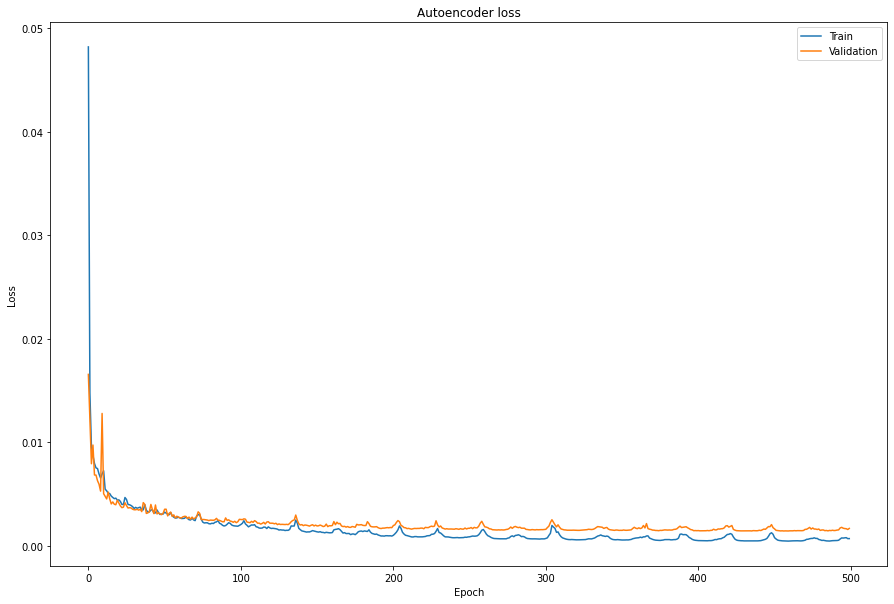

<Figure size 432x288 with 0 Axes>

In [40]:
#plot train and validation loss of pretraining
plt.figure(figsize=(15,10))
plt.plot(autoencoder.history.history['loss'])
plt.plot(autoencoder.history.history['val_loss'])
plt.title('Autoencoder loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

#path = 'results/metrics_training/loss_autoencoder_pretrain.png'
#plt.savefig(path)

# Show prediction after pretraining CAE

In [41]:
#predict images and display

directories = ['data/train/', 
               'data/val/', 
               'data/test/']

scans=['CT','MRI','PET']

def PickListImagesPerType(directory,scan):
    names = [f for f in listdir(directory) if f[:2]==scan[:2]]
    return names

def PickOneImage(names,directory,n):
    image = io.imread(directory+names[n])
    image = cv2.resize(image, dsize=(128,128))
    return image

## Prediction on test dataset

Da riscrivere meglio scrivendo una funzione pred(path della directory di immagini (train, val, test)).
È tutto qui sotto è solo da mettere in un'unica funzione!

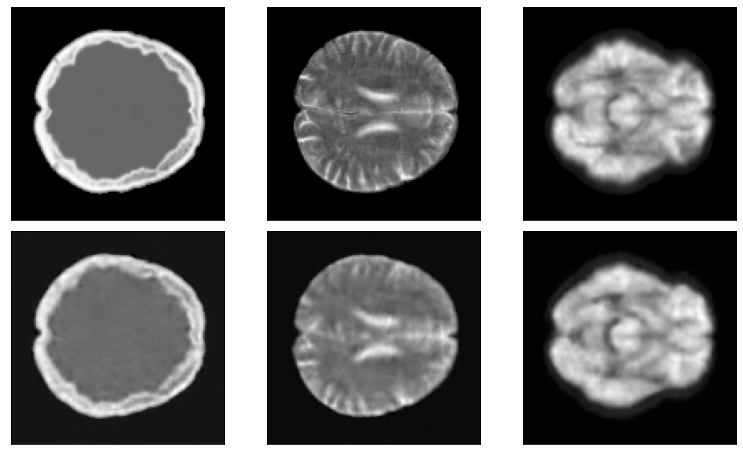

In [42]:
#image layer to display (change this to display different images and respective decoded ones)
n = 6

#ORIGINAL IMAGES
#pick one image per type of scan
imgsCT = PickOneImage(PickListImagesPerType(directories[2],scans[0]),directories[2],n)
imgsMRI = PickOneImage(PickListImagesPerType(directories[2],scans[1]),directories[2],n)
imgsPET = PickOneImage(PickListImagesPerType(directories[2],scans[2]),directories[2],n)

#DECODED IMAGES
#costruisco la lista di immagini da decodificare
listaCT=[]
for f in PickListImagesPerType(directories[2],scans[0]): 
    listaCT.append(join(directories[2], f))

listaMRI=[]
for f in PickListImagesPerType(directories[2],scans[1]): 
    listaMRI.append(join(directories[2], f))
    
listaPET=[]
for f in PickListImagesPerType(directories[2],scans[2]): 
    listaPET.append(join(directories[2], f))

#decode images per type of scan
decoded_imgsCT = autoencoder.predict(ReshapeCAE(WriteAndArrayImages(listaCT)))
decoded_imgsMRI = autoencoder.predict(ReshapeCAE(WriteAndArrayImages(listaMRI)))
decoded_imgsPET = autoencoder.predict(ReshapeCAE(WriteAndArrayImages(listaPET)))

#select one decoded image and make in plottable
decoded_imgCT = decoded_imgsCT[n].reshape(128,128)
decoded_imgMRI = decoded_imgsMRI[n].reshape(128,128)
decoded_imgPET = decoded_imgsPET[n].reshape(128,128)

fig = plt.figure(figsize=(13,10))

#plot images
ax = plt.subplot(2,3,1)
plt.imshow(imgsCT)
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(2,3,2)
plt.imshow(imgsMRI)
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(2,3,3)
plt.imshow(imgsPET)
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(2,3,4)
plt.imshow(decoded_imgCT)
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(2,3,5)
plt.imshow(decoded_imgMRI)
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(2,3,6)
plt.imshow(decoded_imgPET)
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

plt.subplots_adjust(wspace=0.2, hspace=-0.3)

# DCEC Model

In [74]:
#autoencoder.save_weights(save_dir+'/cae_upsampling2D_weights.h5')
autoencoder.load_weights(save_dir+'/cae_conv2Dtranspose_weights.h5')

### Clustering Layer

In [75]:
from keras.engine.topology import Layer

class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=3))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: degrees of freedom parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
         Measure the similarity between embedded point z_i and centroid µ_j.
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) # Make sure each sample's 10 values add up to 1.
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [76]:
from keras.engine.topology import InputSpec

clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=[clustering_layer, autoencoder.output])

In [77]:
###### PLOT HERE THE MODEL.

#from keras.utils import plot_model

#plot_model(model, to_file='model.png', show_shapes=True)

## Inizialize cluster centers using k-means

In [78]:
from sklearn.cluster import KMeans
import metrics as metrics

kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x_train))
y_pred_last = np.copy(y_pred)
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

In [79]:
print('Metrics before training.')
print('acc=', metrics.acc(y_train, y_pred), 'nmi=', metrics.nmi(y_train, y_pred), 'ari=', metrics.ari(y_train, y_pred))

Metrics before training.
acc= 0.44755244755244755 nmi= 0.09622064971404681 ari= 0.022511913145457006


/home/phil/anaconda3/envs/tesi/lib/python3.8/site-packages/sklearn/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


In [ ]:
#feature_model = Model(input=encoder.input, outputs=clustering_layer)
features = model.predict(x_train)[0]

plt.figure(figsize=(10,10))
plt.scatter(features[:,0], features[:,1], c=y_pred, s=50, cmap='brg')

centers = kmeans.cluster_centers_
plt.scatter(centers[:,0], centers[:,1], c='black', s=200, alpha=0.5)

# Training DCEC

In [85]:
# Student's distribution (see paper)
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

In [86]:
# hyperparams
batch_size= 32
maxiter = 50000
update_interval = 100
save_interval = 1000
tol = 0.001 # tolerance as threshold to early stopping

# init 
#train_loss = [0,0,0]
#val_loss = [0,0,0]
#index = 0
train_index_array = np.arange(x_train.shape[0])
#val_index_array = np.arange(x_val.shape[0])

# plots
history_train_losses = [[],[],[]]
#history_val_losses = [[],[],[]]
history_train_acc=[]
#history_val_acc=[]
iterazione=[]

In [87]:
gamma = 0.1
optimizer = 'adam'

model.compile(loss=['kld', 'mse'], loss_weights=[gamma, 1], optimizer=optimizer)

## Train

In [ ]:
import metrics

for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q, _ = model.predict(x_train, verbose=0)
        #qval, _ = model.predict(x_val, verbose=0)
        p = target_distribution(q) # update the auxiliary target distribution p
        #pval = target_distribution(qval)
        #import pdb; pdb.set_trace()

        # evaluate the clustering performance
        y_train_pred = q.argmax(1)
        #y_val_pred = qval.argmax(1)
        if y_train is not None:
            train_acc = np.round(metrics.acc(y_train, y_train_pred), 5)
            train_nmi = np.round(metrics.nmi(y_train, y_train_pred), 5)
            train_ari = np.round(metrics.ari(y_train, y_train_pred), 5)
            train_loss = np.round(train_loss, 5)
            print('Iter', ite, ': Acc tr', train_acc, ', nmi tr', train_nmi, ', ari tr', train_ari, '; tr_loss=', train_loss)
        #if y_val is not None:
        #    val_acc = np.round(metrics.acc(y_val, y_val_pred), 5)
        #    val_nmi = np.round(metrics.nmi(y_val, y_val_pred), 5)
        #    val_ari = np.round(metrics.ari(y_val, y_val_pred), 5)
        #    val_loss = np.round(val_loss, 5)
        #    print('Iter', ite, ': Acc val', val_acc, ', nmi tr', val_nmi, ', ari tr', val_ari, '; val_loss=', val_loss) 
            
        # check stop criterion
        delta_label = np.sum(y_train_pred != y_pred_last).astype(np.float32) / y_train_pred.shape[0]
        y_pred_last = np.copy(y_train_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    
    # train on batch
    idx_train = train_index_array[index * batch_size: min((index+1) * batch_size, x_train.shape[0])]

    train_loss = model.train_on_batch(x=x_train[idx_train], 
                                      y=[p[idx_train], x_train[idx_train]])
    history_train_losses[0].append(train_loss[0])
    history_train_losses[1].append(train_loss[1])
    history_train_losses[2].append(train_loss[2])
    history_acc.append(train_acc)

    #idx_val = val_index_array[index * batch_size: min((index+1) * batch_size, x_val.shape[0])]
    #val_loss = model.test_on_batch(x=x_val[idx_val], 
    #                               y=[pval[idx_val], x_val[idx_val]])
    #history_val_losses[0].append(val_loss[0])
    #history_val_losses[1].append(val_loss[1])
    #history_val_losses[2].append(val_loss[2])
    #history_acc.append(val_acc)
    
    index = index + 1 if (index + 1) * batch_size <= x_train.shape[0] else 0
    
    iterazione.append(ite)
    
    if ite % save_interval == 0:
        # save DCEC model checkpoints
        print('saving model to:', save_dir + '/dcec_model_' + str(ite) + '.h5')
        model.save_weights(save_dir + '/dcec_model_' + str(ite) + '.h5')

# save the trained model
print('saving model to:', save_dir + '/dcec_model_final.h5')
model.save_weights(save_dir + '/dcec_model_final.h5')

/home/phil/anaconda3/envs/tesi/lib/python3.8/site-packages/sklearn/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


Iter 0 : Acc tr 0.44755 , nmi tr 0.09622 , ari tr 0.02251 ; tr_loss= [0.03686 0.16572 0.02028]
saving model to: ./results/dcec_model_0.h5


/home/phil/anaconda3/envs/tesi/lib/python3.8/site-packages/sklearn/utils/linear_assignment_.py:124: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


Iter 100 : Acc tr 0.47086 , nmi tr 0.12269 , ari tr 0.0347 ; tr_loss= [0.00449 0.02671 0.00182]


## Validation

## Plot DCEC tr and val loss

ValueError: x and y must have same first dimension, but have shapes (135,) and (0,)

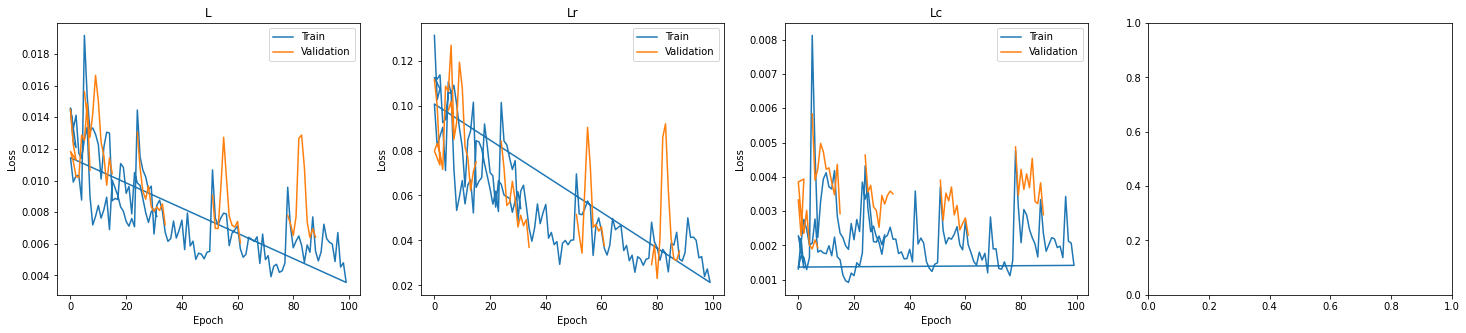

In [63]:
plt.figure(figsize=(25,5))
plt.subplot(1,4,1)
x1=iterazione
y1=history_train_losses[0]
y2=history_val_losses[0]
plt.plot(x1,y1)
plt.plot(x1,y2)
plt.title('L')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.subplot(1,4,2)
x1=iterazione
y1=history_train_losses[1]
y2=history_val_losses[1]
plt.plot(x1,y1)
plt.plot(x1,y2)
plt.title('Lr: reconstruction loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.subplot(1,4,3)
x1=iterazione
y1=history_train_losses[2]
y2=history_val_losses[2]
plt.plot(x1,y1)
plt.plot(x1,y2)
plt.title('Lc: clustering loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.subplot(1,4,4)
x1=iterazione
y1=history_train_acc
y2=history_val_acc
plt.plot(x1,y1)
plt.plot(x1,y2)
plt.title('Acc')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend('Train')

plt.show()

# Final evaluation on test dataset

In [ ]:
q, _ = model.predict(x_test, verbose=0)
p = target_distribution(q) 

test_loss = model.fit(x=x_test, y=[p, x_test])
print(' Acc', acc) 

## Show prediction after pretraining DCEC

### Prediction on test dataset

In [ ]:
#image layer to display (change this to display different images and respective decoded ones)
n = 8 

#ORIGINAL IMAGES
#pick one image per type of scan
imgsCT = PickOneImage(PickListImagesPerType(directories[2],scans[0]),directories[2],n)
imgsMRI = PickOneImage(PickListImagesPerType(directories[2],scans[1]),directories[2],n)
imgsPET = PickOneImage(PickListImagesPerType(directories[2],scans[2]),directories[2],n)

#DECODED IMAGES
#costruisco la lista di immagini da decodificare
listaCT=[]
for f in PickListImagesPerType(directories[2],scans[0]): 
    listaCT.append(join(directories[2], f))

listaMRI=[]
for f in PickListImagesPerType(directories[2],scans[1]): 
    listaMRI.append(join(directories[2], f))
    
listaPET=[]
for f in PickListImagesPerType(directories[2],scans[2]): 
    listaPET.append(join(directories[2], f))

#decode images per type of scan
decoded_imgsCT = model.predict(ReshapeCAE(WriteAndArrayImages(listaCT)))[1]
decoded_imgsMRI = model.predict(ReshapeCAE(WriteAndArrayImages(listaMRI)))[1]
decoded_imgsPET = model.predict(ReshapeCAE(WriteAndArrayImages(listaPET)))[1]

#select one decoded image and make in plottable
decoded_imgCT = decoded_imgsCT[n].reshape(128,128)
decoded_imgMRI = decoded_imgsMRI[n].reshape(128,128)
decoded_imgPET = decoded_imgsPET[n].reshape(128,128)



#plot images
fig = plt.figure(figsize=(13,10))

ax = plt.subplot(2,3,1)
plt.imshow(imgsCT)
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(2,3,2)
plt.imshow(imgsMRI)
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(2,3,3)
plt.imshow(imgsPET)
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(2,3,4)
plt.imshow(decoded_imgCT)
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(2,3,5)
plt.imshow(decoded_imgMRI)
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax = plt.subplot(2,3,6)
plt.imshow(decoded_imgPET)
plt.gray()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# Plotting clusters

### Train

In [ ]:
features = feature_model.predict(x_train)
y_pred = km.fit_predict(features)
plt.figure(figsize=(12,10))
plt.scatter(features[:,0], features[:,1], c=y_pred, s=50, cmap='brg')
centers = km.cluster_centers_
plt.scatter(centers[:,0], centers[:,1], c='black', s=200, alpha=0.5)

### Test

In [ ]:
features = feature_model.predict(x_test)
y_pred = km.fit_predict(features)
plt.figure(figsize=(12,10))
plt.scatter(features[:,0], features[:,1], c=y_pred, s=50, cmap='brg')
centers = km.cluster_centers_
plt.scatter(centers[:,0], centers[:,1], c='black', s=200, alpha=0.5)

## Confusion matrix

In [ ]:
import seaborn as sns
import sklearn.metrics
import matplotlib.pyplot as plt
sns.set(font_scale=3)
confusion_matrix = sklearn.metrics.confusion_matrix([int(i) for i in y_test], y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Clustering label')
plt.show()

In [ ]:
from sklearn.utils.linear_assignment_ import linear_assignment

y_true = y.astype(np.int64)
D = max(y_pred.max(), y_true.max()) + 1
w = np.zeros((D, D), dtype=np.int64)
# Confusion matrix.
for i in range(y_pred.size):
    w[y_pred[i], y_true[i]] += 1
ind = linear_assignment(-w)

sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

In [ ]:
ind